# Statistics per gene

## The python script
This code determines statistics based on the results obtained in the _pergene.txt file by the Matlab code provided by the Kornmann lab.
The _pergene.txt file consists of three columns.
The rows in the first column contains all genes of * S.Cerevisiae*, the corresponding transposon count is stored in the second column and the third column contains the reads.

The genes in this file are split into two groups based on their essentiality.
This is determined using two files that contains all known essential genes.

The data is represented as a violinplot where both the essential and non-essential genes are shown.

Some basic statistics are determined here, but this can be extended with more if needed.

### Input

Data that needs to be loaded:

1. filepath: Path to the output text file the Matlab code of Benoit that includes the read and transposon count per gene (with extension _pergene.txt)
2. filename: Name of this file.
3. normalize: Whether or not to normalize the transposon and read counts to the gene lengths (True or False)
4. essential_genes_files: List of essential genes. Can be input as multiple files which will be automatically merged.
5. gene_information_file: List of genes with their possible aliasses and lengths in amino acids.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
file_dirname = os.path.dirname('__file__')
# sys.path.insert(1,os.path.join(file_dirname,'python_modules'))
# os.chdir('mini_book/docs/Python_scripts/python_modules/')

filepath = os.path.join(file_dirname,'satay_analysis_testdata','Output_Processing')
filename = "Cerevisiae_WT2_Michel2017_trimmed1.bam_pergene.txt" # CHANGE THIS TO ANY FILE YOU WANT TO ANALYSE.
normalize = 'True'

essential_genes_files = [os.path.join(file_dirname,'Python_scripts','Data_Files','Cervisiae_EssentialGenes_List_1.txt'),
                        os.path.join(file_dirname,'Python_scripts','Data_Files','Cervisiae_EssentialGenes_List_2.txt')]

gene_information_file = os.path.join(file_dirname,'Python_scripts','Data_Files','Yeast_Protein_Names.txt')
# os.chdir('mini_book/docs/Python_scripts/')

### Create list of all essential genes
This can be input from multiple files given in the `essential_genes_files` variable that are merged in one list.

In [3]:
known_essential_gene_list = []

for files in essential_genes_files:
    with open(files) as f:
        for header_lines in range(3):
            next(f)
        for lines in f:
            known_essential_gene_list.append(lines.rstrip('\n'))

### Create a dictionary with length all genes
Dictionary consists of keys which are all genes (including all their potential aliasses and different naming conventions) and of values which are the length in terms of base pairs.
The number of base pairs is calculated by multiplying the number of amino acids by 3.

In [4]:
# CREATE A DICTIONARY WITH ALL GENES (BOTH THE COMMON NAME AND THEIR SYSTEMATIC NAME) AND SAVE THEM WITH THEIR RESPECTIVE LENGHTS (IN TERMS OF BP WHICH IS DEFINED AS bp=aa*3)
gene_length_dict = {}
with open(gene_information_file) as f:
    lines = f.readlines()

# THE GENES START AT LINE 58 AND STOP 6 LINES BEFORE THE END OF THE FILE.
    for i in range(58,len(lines)-6):
        n=0
        l = lines[i]

# COUNT HOW MANY TIMES ';' OCCURS IN A LINE.
        extra_columns = l.count(';')
        l_short = ' '.join(l.split())
        l_list = l_short.split(' ')

# IGNORE SEQUENCES THAT ARE NOT NEEDED.
        if l_list[1+extra_columns] == 'GAG' or l_list[1+extra_columns] == 'POL':
            extra_columns = extra_columns + 1

# DETERMINE GENE LENGTH AND STORE WITH THE CORRESPONDING GENE NAME (e.g. Cdc42)
        gene_length_dict[l_list[0].strip(';')] = int(l_list[5+extra_columns])*3

# DETERMINE GENE LENGTH AND STORE WITH THE CORRESPONDING GENE SYSTEMATIC NAME (e.g. YLR229C)
        gene_length_dict[l_list[1+extra_columns]] = int(l_list[5+extra_columns])*3

# DETERMINE GENE LENGTH AND STORE WITH THE CORRESPONDING GENE ALIASES (IF PRESENT).
        if extra_columns > 0:
            for n in range(extra_columns+1):
                gene_length_dict[l_list[0+n].strip(';')] = int(l_list[5+extra_columns])*3

### Create lists with information to be plotted
Lists are made for

1. Gene names
2. Reads per gene 
3. Transposons per gene 
4. Whether or not a gene is essential or not (contains only True and False statements)
5. Reads per gene normalized to the length of each gene in terms of base pairs
6. Transposons per gene normalized to the length of each gene in terms of base pairs

The gene_counter counts the number of genes included in the analysis. The fail_counter are the number of genes that are present in the data, but could be found in the list of gene lengths and could therefore not be normalized. These genes are ignored. This should not be much more than 0.5% of the total amount of genes.

In [5]:
file = os.path.join(filepath,filename)

with open(file) as f:
    lines = f.readlines()

In [6]:
gene_name_list = [] # LIST OF ALL GENES ANALYZED AND OUTPUT BY THE MATLAB CODE OF BENOIT.
reads_pergene_list = [] # NUMBER OF READS PER GENE AS DETERMINED BY THE MATLAB CODE OF BENOIT.
tn_pergene_list = [] # NUMBER OF TRANSPOSONS PER GENE AS DETERMINED BY THE MATLAB CODE OF BENOIT.
gene_essential_boolean_list = [] # WHICH OF THE GENES ANALYZED ARE ESSENTIAL (MARKED AS TRUE) AND NON ESSENTIAL (MARKED AS FALSE)
reads_pergene_norm_list = [] # NUMBER OF READS PER GENE AS DETERMINED BY THE MATLAB CODE OF BENOIT NORMALIZED FOR THE LENGTH OF THE GENES IN TERMS OF BASEPAIRS.
tn_pergene_norm_list = [] # NUMBER OF TRANSPOSONS PER GENE AS DETERMINED BY THE MATLAB CODE OF BENOIT NORMALIZED FOR THE LENGTH OF THE GENES IN TERMS OF BASEPAIRS.

gene_counter = 0
fail_counter = 0
failed_genes_list = []
for line in lines[1:]:
    split_line = line.split('\t')
    gene_name = split_line[0].rstrip()


    if len(split_line) > 1:
        tn_pergene = int(split_line[1])
    else:
        tn_pergene = np.nan


    if len(split_line) > 2:
        reads_pergene = int(split_line[2])
    else:
        reads_pergene = np.nan

    reads_pergene_list.append(reads_pergene)
    tn_pergene_list.append(tn_pergene)


#!!! GENES WITH ALIASES ARE COUNTED DOUBLE IF ONE OR MORE ALIASES ARE PRESENT IN THE ESSENTIAL GENES LIST !!!
    if normalize == False:
        if gene_name in known_essential_gene_list:
            gene_essential_boolean_list.append(True) 
        else:
            gene_essential_boolean_list.append(False)
        gene_name_list.append(gene_name)

    else:
        gene_length = gene_length_dict.get(gene_name)
        try:
            reads_pergene_norm_list.append(reads_pergene/gene_length)
            tn_pergene_norm_list.append(tn_pergene/gene_length)

            if gene_name in known_essential_gene_list:
                gene_essential_boolean_list.append(True) 
            else:
                gene_essential_boolean_list.append(False)
            gene_name_list.append(gene_name)

            gene_counter = gene_counter + 1
        except:
            fail_counter = fail_counter + 1
            failed_genes_list.append(gene_name)

print('Number of genes analyzed: ',gene_counter)
print('Number of genes not found: %.0f (%.2f percent) '% (fail_counter, fail_counter/(gene_counter+fail_counter)*100))
print('Genes not found: ',failed_genes_list)

Number of genes analyzed:  6586
Number of genes not found: 17 (0.26 percent) 
Genes not found:  ['COX26', 'ARG5', 'COM2', 'ADE5', 'MF', 'CIA2', 'KCH1', 'FAT3', 'INA1', 'EPO1', 'ERG29', 'SPR2', 'BIL1', 'TFB6', 'PBI1', 'MF', 'NVJ2']


### Create dataframe
This puts the data in the form of a dataframe (part of the `pandas` package). This is necessary for plotting.

In [7]:
if normalize == False:
    genes = {'Gene_name': gene_name_list,
            'Transposons_per_gene': tn_pergene_list,
            'Reads_per_gene': reads_pergene_list,
            'Essential_gene': gene_essential_boolean_list
            }
    df = pd.DataFrame(genes,columns=['Gene_name','Transposons_per_gene','Reads_per_gene', 'Essential_gene'])
else:
    genes = {'Gene_name': gene_name_list,
            'Transposon_density_per_gene': tn_pergene_norm_list,
            'Read_density_per_gene': reads_pergene_norm_list,
            'Essential_gene': gene_essential_boolean_list
            }
    df = pd.DataFrame(genes,columns=['Gene_name','Transposon_density_per_gene','Read_density_per_gene', 'Essential_gene'])

### Print statistics

In [8]:
print('Average number of reads all genes: %.0f ' % np.nanmean(reads_pergene_list))
print('Median number of reads all genes: %.0f ' % np.nanmedian(reads_pergene_list))
print('Standard Deviation number of reads all genes: %.0f ' % np.nanstd(reads_pergene_list))
print('')

print('Average number of transposons all genes: %.0f ' % np.nanmean(tn_pergene_list))
print('Median number of transposons all genes: %.0f ' % np.nanmedian(tn_pergene_list))
print('Standard Deviation number of transposons all genes: %.0f ' % np.nanstd(tn_pergene_list))
print('')
print('')



indices_essential_genes_list = [i for i, x in enumerate(gene_essential_boolean_list) if x == True]
reads_peressentialgene_list = [reads_pergene_list[i] for i in indices_essential_genes_list]
print('Average number of reads of essential genes: %.0f ' % np.nanmean(reads_peressentialgene_list))
print('Median number of reads of essential genes: %.0f ' % np.nanmedian(reads_peressentialgene_list))
print('Maximum number of reads of essential genes: %.0f ' % np.nanmax(reads_peressentialgene_list))
print('Minimum number of reads of essential genes: %.0f ' % np.nanmin(reads_peressentialgene_list))
print('')

indices_nonessential_genes_list = [i for i, x in enumerate(gene_essential_boolean_list) if x == False]
reads_pernonessentialgene_list = [reads_pergene_list[i] for i in indices_nonessential_genes_list]
print('Average number of reads of nonessential genes: %.0f ' % np.nanmean(reads_pernonessentialgene_list))
print('Median number of reads of nonessential genes: %.0f ' % np.nanmedian(reads_pernonessentialgene_list))
print('Maximum number of reads of nonessential genes: %.0f ' % np.nanmax(reads_pernonessentialgene_list))
print('Minimum number of reads of nonessential genes: %.0f ' % np.nanmin(reads_pernonessentialgene_list))
print('')
print('')



tn_peressentialgene_list = [tn_pergene_list[i] for i in indices_essential_genes_list]
print('Average number of transposons of essential genes: %.0f ' % np.nanmean(tn_peressentialgene_list))
print('Median number of transposons of essential genes: %.0f ' % np.nanmedian(tn_peressentialgene_list))
print('Standard deviation number of transposons of essential genes: %.0f ' % np.nanstd(tn_peressentialgene_list))
print('Maximum number of transposons of essential genes: %.0f ' % np.nanmax(tn_peressentialgene_list))
print('Minimum number of transposons of essential genes: %.0f ' % np.nanmin(tn_peressentialgene_list))
print('')

tn_pernonessentialgene_list = [tn_pergene_list[i] for i in indices_nonessential_genes_list]
print('Average number of transposons of nonessential genes: %.0f ' % np.nanmean(tn_pernonessentialgene_list))
print('Median number of transposons of nonessential genes: %.0f ' % np.nanmedian(tn_pernonessentialgene_list))
print('Standard deviation number of transposons of nonessential genes: %.0f ' % np.nanstd(tn_pernonessentialgene_list))
print('Maximum number of transposons of nonessential genes: %.0f ' % np.nanmax(tn_pernonessentialgene_list))
print('Minimum number of transposons of nonessential genes: %.0f ' % np.nanmin(tn_pernonessentialgene_list))
print('')

Average number of reads all genes: 2235 
Median number of reads all genes: 767 
Standard Deviation number of reads all genes: 7935 

Average number of transposons all genes: 74 
Median number of transposons all genes: 43 
Standard Deviation number of transposons all genes: 100 


Average number of reads of essential genes: 2747 
Median number of reads of essential genes: 794 
Maximum number of reads of essential genes: 158981 
Minimum number of reads of essential genes: 0 

Average number of reads of nonessential genes: 2125 
Median number of reads of nonessential genes: 761 
Maximum number of reads of nonessential genes: 154652 
Minimum number of reads of nonessential genes: 0 


Average number of transposons of essential genes: 82 
Median number of transposons of essential genes: 46 
Standard deviation number of transposons of essential genes: 112 
Maximum number of transposons of essential genes: 867 
Minimum number of transposons of essential genes: 0 

Average number of transposon

### Create a histogram
A histogram is plotted where the number of reads and number of transposons are shown for essential and non-essential genes together.
This shows the distribution of the number of reads and insertions for the complete dataset.

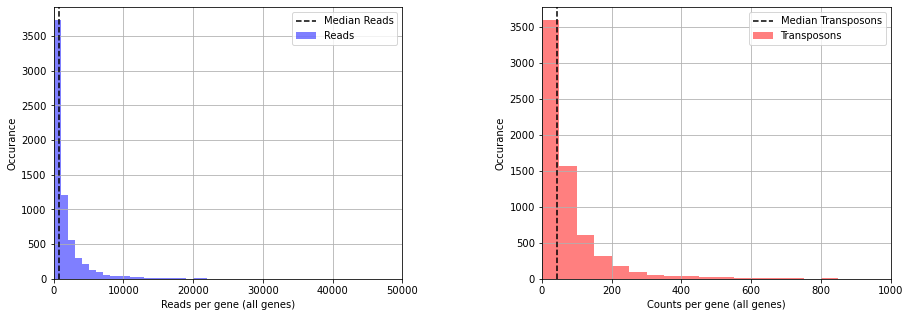

In [9]:
plt.figure(figsize=(15,5))
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

ax1 = plt.subplot(grid[0,0])
n_reads,bins_reads,patches_reads = ax1.hist(reads_pergene_list, density=False, bins=range(min(reads_pergene_list), max(reads_pergene_list) + 1000, 1000), facecolor='blue',alpha=0.5, label='Reads')
ax1.axvline(x=np.nanmedian(reads_pergene_list), linestyle='--', label='Median Reads', color='k')
ax1.set_xlim([0,50000])
ax1.set_xlabel('Reads per gene (all genes)')
ax1.set_ylabel('Occurance')
ax1.legend()
ax1.grid()

ax2 = plt.subplot(grid[0,1])
n_tn,bins_tn,patches_tn = ax2.hist(tn_pergene_list, density=False, bins=range(min(tn_pergene_list), max(tn_pergene_list) + 50, 50), facecolor='red',alpha=0.5, label='Transposons')
ax2.axvline(x=np.nanmedian(tn_pergene_list), linestyle='--', label='Median Transposons', color='k')
ax2.set_xlim([0,1000])
ax2.set_xlabel('Counts per gene (all genes)')
ax2.set_ylabel('Occurance')
ax2.legend()
ax2.grid()
plt.show()

### Create a violin plot
This shows the distribution for the reads and insertions for the dataset separated by annotated essentiality.

When `normalization` is set to `True`, the plots represent read- and transposon densities. Otherwise the plots show the actual counts.

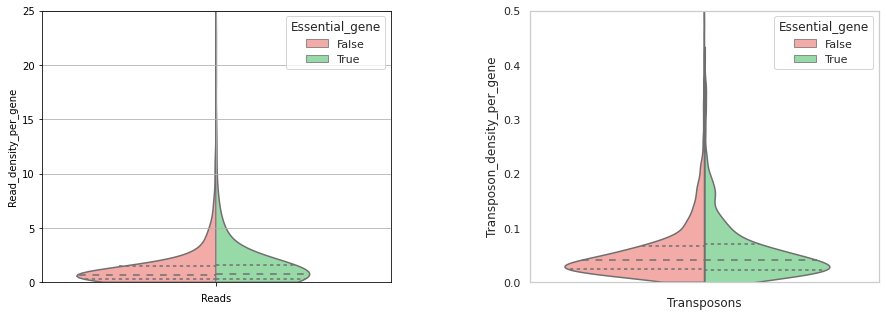

In [10]:
plt.figure(figsize=(15,5))
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)


ax1 = plt.subplot(grid[0,0])
sns.set(style='whitegrid', palette='pastel', color_codes=True)
df['Reads'] = ''
if normalize == 'False':
    sns.violinplot(x='Reads',y="Reads_per_gene", hue='Essential_gene', inner='quarter', gridsize=1000, palette={False:'r', True:'g'}, split=True, cut=0, orient='v', data=df, ax=ax1)
else:
    sns.violinplot(x='Reads',y="Read_density_per_gene", hue='Essential_gene', inner='quarter', gridsize=1000, palette={False:'r', True:'g'}, split=True, cut=0, orient='v', data=df, ax=ax1)
ax1.set_ylim([0,25])
ax1.grid()


ax2 = plt.subplot(grid[0,1])
df['Transposons'] = ''
if normalize == False:
    sns.violinplot(x='Transposons',y="Transposons_per_gene", hue='Essential_gene', inner='quarter', gridsize=1000, palette={'False':'r', 'True':'g'}, split=True, cut=0, orient='v', data=df, ax=ax2)
else:
    sns.violinplot(x='Transposons',y="Transposon_density_per_gene", hue='Essential_gene', inner='quarter', gridsize=1000, palette={False:'r', True:'g'}, split=True, cut=0, orient='v', data=df, ax=ax2)
ax2.set_ylim([0.0,0.5])
ax2.grid()

plt.show()

## Interpretation

Initially it is expected that the number of reads and the number of insertions are higher for the non-essential genes as these are more tolerant to transposons than the essential genes.
Note that 'essential' means 'annotated essential' here, and not 'essential based on the data'.
It might occur that genes are annotated as (non-)essential, but that this does not agree with the data.
This might skew the data shown in the graphs, but since it is expected that these situations do not occur frequently these graphs can still give a good indication about the differences in number of reads and insertions per (non-)essential gene.

Ideally the median values of the essential and nonessential genes are far apart from each other, so that a clear distinction can be made between which genes are essential and which are not based on the transposon counts. If this is not the case or when there is significant overlap between the distribution, no definite conclusion can be drawn about the essentiality.

Usually, essential genes have little transposon counts, but nonessential genes can have both high or low transposon counts (for an explanation on this effect, see the paper by Michel et.al. 2017).
This means that if a high transposon count occurs, the gene is probably nonessential.
But if a low transposon count is present, typically no definite conclusion can be drawn about its essentiality.

## Bibliography
- Michel, A. H., Hatakeyama, R., Kimmig, P., Arter, M., Peter, M., Matos, J., ... & Kornmann, B. (2017). Functional mapping of yeast genomes by saturated transposition. Elife, 6, e23570.
- Segal, E. S., Gritsenko, V., Levitan, A., Yadav, B., Dror, N., Steenwyk, J. L., ... & Kunze, R. (2018). Gene essentiality analyzed by in vivo transposon mutagenesis and machine learning in a stable haploid isolate of Candida albicans. MBio, 9(5), e02048-18.